## Imports

In [249]:
import json
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np
from numpy import linalg as LA

import pandas as pd

import networkx as nx
import community

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

## Data preparation
### Loading of the data

In [209]:
# Download names to make it more friendly
json_file_path_1 = '../data/all_coins_by_mc_1.json'
json_file_path_2 = '../data/all_coins_by_mc_2.json'

# Open the JSON file and load its contents
with open(json_file_path_1, 'r') as file:
    data = json.load(file)

with open(json_file_path_2, 'r') as file:
    data = data + json.load(file)
# Now, 'data' contains the contents of the JSON file as a Python object (dictionary, list, etc.)
names_list = [stock["name"] for stock in data]

### Load price data and preprocessing

In [210]:
data = pd.read_csv("../data/processed/prices.csv", parse_dates=['date'])
data.rename(columns={data.columns[0]: 'date'}, inplace=True)
data.set_index("date", inplace=True)
data.columns = names_list
data = data.loc['2021-01-01':'2022-12-31'] # Filter
data = data.dropna(axis=1, how='all') # Drop all columns that contains only null value
data = data.dropna(axis=1, thresh=0.95*len(data.index)) # Drop columns that contains more than 25% of null value
data = data.ffill() # ffill null values
data.dropna(inplace=True)

### Compute and normalize Hourly log-return

In [211]:
hourly_returns_pct = data.pct_change()
hourly_returns_pct = hourly_returns_pct.iloc[1:]
hourly_returns_pct.to_csv("../data/processed/hourly_return.csv")
hourly_log_returns = np.log(hourly_returns_pct + 1)

In [212]:
scaler = StandardScaler()
hourly_log_returns = pd.DataFrame(scaler.fit_transform(hourly_log_returns), columns=hourly_log_returns.columns, index=hourly_log_returns.index)
hourly_log_returns.to_csv("../data/processed/normalized_log_ret.csv")

## Network creation methods

### Eigenvvalues clipping

In [213]:
def compute_C_minus_C0(lambdas, v, lambda_plus, removeMarketMode=False):
    N=len(lambdas)
    C_clean=np.zeros((N, N))

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]

    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):
        if lambdas[i]>lambda_plus:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)
    return C_clean

### From C (as in class)

In [214]:
def baseline_network(R, mst=False):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    C=R.corr()
    lambdas, v = LA.eigh(C)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    C_s = np.abs(C_s)

    return nx.from_numpy_array(C_s)


### Minimum Spanning Tree

In [215]:
def mst_network(R):
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    C=R.corr()
    lambdas, v = LA.eigh(C)
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    # Compute distance matrix
    D = np.sqrt(2*(1-C_s))
    # Compute MST
    G = nx.from_numpy_array(D)
    return nx.minimum_spanning_tree(G)

### Threshold network
- Compute C and D
- Create G from D
- Remove all edge with weight smaller than *threshold*
- Louvain clustering

In [216]:
def threshold_network(R, threshold=1.41):
    N = R.shape[1]
    T = R.shape[0]
    
    # Compute lambda_plus and correlation matrix
    q = N * 1. / T
    lambda_plus = (1. + np.sqrt(q)) ** 2
    C = R.corr()
    lambdas, v = LA.eigh(C)
    C = compute_C_minus_C0(lambdas, v, lambda_plus)

    # Compute distance matrix
    D = np.sqrt(2*(1-C))    
    
    # Compute graph
    G = nx.from_numpy_array(D)
    edges_to_remove = [edge for edge, attr in G.edges.items() if attr['weight'] >= threshold]
    G.remove_edges_from(edges_to_remove)
    return G

### Planar Maximally Filtered Graph

In [217]:
def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data['weight']})
        
    return sorted_edges

def compute_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    for edge in sorted_edges:
        PMFG.add_edge(edge['source'], edge['dest'])
        if not nx.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
            
        if len(PMFG.edges()) == 3*(nb_nodes-2):
            print('test')
            break
    
    return PMFG


def pmfg_network(R):
    N = R.shape[1]
    T = R.shape[0]
    
    # Compute lambda_plus and correlation matrix
    q = N * 1. / T
    lambda_plus = (1. + np.sqrt(q)) ** 2
    C = R.corr()
    lambdas, v = LA.eigh(C)
    C = compute_C_minus_C0(lambdas, v, lambda_plus)

    # Compute distance matrix
    D = np.sqrt(2*(1-C))    
    
    # Compute graph
    G = nx.from_numpy_array(D)
    
    sorted_edges = sort_graph_edges(G)
    
    return compute_PMFG(sorted_edges, N)

## Louvain clustering

In [338]:
def louvain_clustering(G, resolution):
    return  community.community_louvain.best_partition(G, resolution=resolution)

## Rolling window

In [286]:
df = pd.read_csv("../data/processed/normalized_log_ret.csv")

In [355]:
def rename_asset(R, partition):
    dict_cluster = {}
    all_names = list(R.columns)
    for i, name in enumerate(all_names):
        dict_cluster[name]=partition[i]
        
    return dict_cluster

def clustering(R: pd.DataFrame, period: int=720, interval: int = 24, method:str='baseline') -> dict:
    """Compute the clusters in a rolling window manner for the return matrix R.

    Args:
        R (pd.Dataframe): Normalized log-return matrix
        period (int, optional): time period_. Defaults to 30 days (720 hours).
        interval (int, optional): time interval. Defaults to 1 day (24 hours).
        method (str, optional): Clustering method. Defaults to 'baseline'. Can be 'baseline', 'mst' 'threshold', 'pmf'.
    """
    cluster_dict = {}
    resolution = 1
    for t0 in tqdm(range(0, len(R.index)-period, interval)):
        R_tmp = R.iloc[t0:t0+period]
        if method == 'baseline':
            G = baseline_network(R_tmp)
            resolution = 1.02
        elif method == 'mst':
            G = mst_network(R_tmp)
            resolution = TODO
        elif method == 'threshold':
            G = threshold_network(R_tmp)
            resolution = TODO
        elif method == 'pmf':
            G = pmfg_network(R_tmp)
            resolution = TODO
        else:
            raise ValueError("Method not recognized")
            
        
        cluster_dict[(t0, t0+period)] = rename_asset(R_tmp, louvain_clustering(G, resolution))
            
    return cluster_dict

In [356]:
clusters = clustering(df.set_index('date'), period=720, interval=24, method='baseline')
clusters

100%|█████████████████████████████████████████| 501/501 [08:30<00:00,  1.02s/it]


{(0, 720): {'Bitcoin': 0,
  'Ethereum': 0,
  'Tether': 1,
  'BNB': 0,
  'XRP': 0,
  'Solana': 0,
  'USDC': 2,
  'Lido Staked Ether': 0,
  'Cardano': 0,
  'Dogecoin': 0,
  'TRON': 0,
  'Chainlink': 0,
  'Avalanche': 0,
  'Polygon': 0,
  'Polkadot': 0,
  'Wrapped Bitcoin': 2,
  'Dai': 2,
  'Litecoin': 0,
  'Shiba Inu': 1,
  'Uniswap': 0,
  'Bitcoin Cash': 0,
  'LEO Token': 2,
  'OKB': 0,
  'Stellar': 0,
  'Monero': 0,
  'TrueUSD': 2,
  'Cosmos Hub': 0,
  'Ethereum Classic': 0,
  'Cronos': 0,
  'Filecoin': 0,
  'Lido DAO': 2,
  'THORChain': 0,
  'Hedera': 0,
  'NEAR Protocol': 2,
  'BUSD': 1,
  'VeChain': 0,
  'Injective': 2,
  'Aave': 0,
  'Quant': 0,
  'Maker': 3,
  'The Graph': 1,
  'Render': 2,
  'MultiversX': 0,
  'Synthetix Network': 0,
  'Algorand': 0,
  'Stacks': 2,
  'Theta Network': 0,
  'Flow': 1,
  'Bitcoin SV': 2,
  'Fantom': 1,
  'The Sandbox': 2,
  'Axie Infinity': 2,
  'IOTA': 1,
  'Decentraland': 1,
  'WEMIX': 0,
  'Terra Luna Classic': 0,
  'NEO': 0,
  'EOS': 0,
  'KuCoi

In [357]:
# View first n cluster

n = 3
for i in range(n):
    dict_clusters = clusters[list(clusters.keys())[i]]
    grouped_cryptos = {}

    for crypto, number in dict_clusters.items():
        if number not in grouped_cryptos:
            grouped_cryptos[number] = []
        grouped_cryptos[number].append(crypto)

    # Convert the dictionary values to a list for easier usage
    result_lists = list(grouped_cryptos.values())

    # Print or use the result_lists as needed
    print("Clustering {} \n".format(i + 1))
    for c in range(len(result_lists)):
        print(result_lists[c])
        print()

Clustering 1 

['Bitcoin', 'Ethereum', 'BNB', 'XRP', 'Solana', 'Lido Staked Ether', 'Cardano', 'Dogecoin', 'TRON', 'Chainlink', 'Avalanche', 'Polygon', 'Polkadot', 'Litecoin', 'Uniswap', 'Bitcoin Cash', 'OKB', 'Stellar', 'Monero', 'Cosmos Hub', 'Ethereum Classic', 'Cronos', 'Filecoin', 'THORChain', 'Hedera', 'VeChain', 'Aave', 'Quant', 'MultiversX', 'Synthetix Network', 'Algorand', 'Theta Network', 'WEMIX', 'Terra Luna Classic', 'NEO', 'EOS', 'KuCoin', 'Tezos', 'Tokenize Xchange', 'Fetch.ai', 'PancakeSwap', 'Curve DAO', 'Gnosis', 'Pax Dollar', 'Zcash', 'NEXO', 'Zilliqa', 'Dash', 'Compound', '0x Protocol', 'Basic Attention', 'Qtum', 'Enjin Coin', 'Siacoin', 'Celo', 'yearn.finance', 'Holo', 'Ocean Protocol', 'Beldex', 'Ankr Network', 'ICON', 'Sushi', 'Golem', 'Kusama', 'Ravencoin', 'OriginTrail', 'Balancer', 'Ontology', 'Band Protocol', 'SwissBorg', 'Livepeer', 'Lisk', 'Harmony', 'ECOMI', 'Stratis', 'UMA', 'Reserve Rights', 'Orbs', 'Energy Web', 'BTSE Token', 'DigiByte', 'STP', 'Cartesi'

## Stability

In [358]:
def compute_rand_score(clusters):
    nb_clusters = len(clusters.keys())
    rand_score = []
    for i in range(nb_clusters - 1):
        score = adjusted_rand_score(list(clusters[list(clusters.keys())[i]].values()), list(clusters[list(clusters.keys())[i+1]].values()))
        rand_score.append(score)
    return rand_score

In [359]:
def compute_nb_clusters(clusters):
    nb_clusters = len(clusters.keys())
    list_nb_clusters = []
    for i in range(nb_clusters - 1):
        nb = max(clusters[list(clusters.keys())[i]].values())
        list_nb_clusters.append(nb)
    return list_nb_clusters

In [360]:
compute_nb_clusters(clusters)

[3,
 4,
 3,
 4,
 3,
 2,
 3,
 2,
 2,
 2,
 4,
 4,
 2,
 3,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 4,
 3,
 3,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 5,
 6,
 4,
 3,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 5,
 4,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 6,
 5,
 4,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 3,
 5,
 12,
 14,
 29,
 29,
 34,
 38,
 32,
 36,
 37,
 43,
 44,
 47,
 44,
 41,
 39,
 44,
 43,
 44,
 40,
 42,
 44,
 44,
 49,
 45,
 49,
 41,
 47,
 48,
 45,
 45,
 42,
 35,
 34,
 32,
 33,
 29,
 20,
 24,
 35,
 39,
 37,
 34,
 32,
 36,
 34,
 32,
 28,
 31,
 29,
 28,
 28,
 24,
 18,
 15,
 19,
 19,
 19,
 18,
 17,
 21,
 15,
 15,
 17,
 17,
 13,
 19,
 23,
 22,
 18,
 18,
 22,
 19,
 19,
 20,
 17,
 16,
 12,
 9,
 12,
 20,
 19,
 16,
 18,
 21,
 18,
 17,
 19,
 18,
 19,
 18,
 19,
 18,
 28,
 27,
 8,
 5,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,

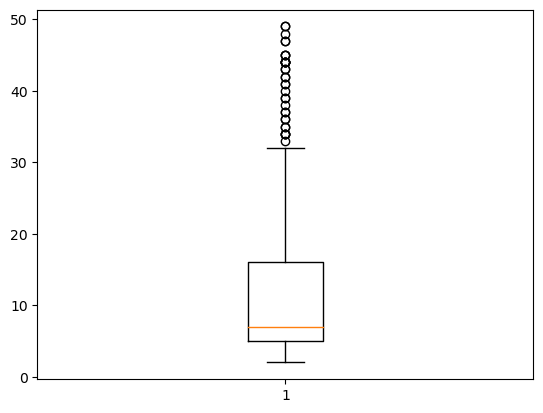

In [361]:
# Nb of clusters
plt.boxplot(compute_nb_clusters(clusters))
plt.show()

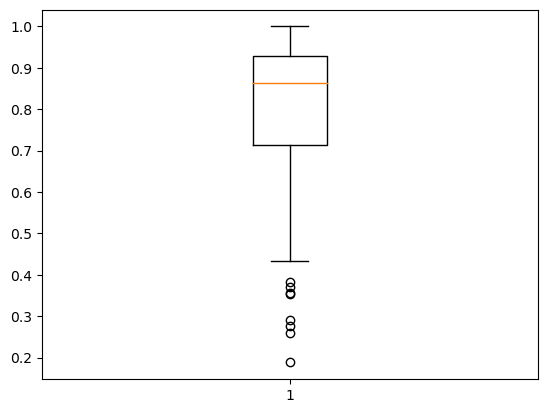

In [362]:
# Stability of the clusters
plt.boxplot(compute_rand_score(clusters))
plt.show()

## Markowitz

In [265]:
def find_representatives(clusters):
    nb_clustering = len(clusters.keys())
    representatives = []
    for i in range(nb_clustering):
        
        current_representatives = []
        current_cluster = clusters[list(clusters.keys())[i]]

        # Loop through each community
        for group in range(max(current_cluster.values())):
            subset = [cluster[0] for cluster in current_cluster.items() if cluster[1] == group]
            # Subset the data for the current group
            subset_data = df[subset]

            imputer = SimpleImputer(strategy='mean')
            subset_data_imputed = pd.DataFrame(imputer.fit_transform(subset_data), columns=subset_data.columns, index=subset_data.index)

            # Standardize/Normalize the data
            scaler = StandardScaler()
            subset_data_standardized = scaler.fit_transform(subset_data_imputed)

            # Apply PCA
            pca = PCA()
            principal_components = pca.fit_transform(subset_data_standardized)

            # Identify the leading coin (biggest contributor in the first principal component)
            leading_coin_index = np.argmax(np.abs(pca.components_[0]))
            leading_coin = subset_data.columns[leading_coin_index]
            current_representatives.append(leading_coin)
            # Print
        representatives.append(current_representatives)
    return representatives

In [267]:
representatives = find_representatives(clusters)
representatives

[['Ethereum',
  'IOTA',
  'Constellation',
  'The Graph',
  'yearn.finance',
  'Viction'],
 ['Wrapped Bitcoin',
  'Ethereum',
  'The Graph',
  'Horizen',
  'Theta Network',
  'IOTA'],
 ['RSK Infrastructure Framework',
  'Wrapped Bitcoin',
  'cWBTC',
  'Theta Network',
  'IOTA',
  'yearn.finance'],
 ['cWBTC', 'IOTA', 'Zilliqa', 'Ethereum', 'Wrapped Bitcoin'],
 ['cWBTC', 'Ethereum', 'Zilliqa', 'Oraichain', 'Wrapped Bitcoin', 'IOTA'],
 ['Ethereum', 'cWBTC', 'Wrapped Bitcoin', 'Chiliz', 'Oraichain'],
 ['cWBTC', 'Ethereum', 'IOTA', 'Wrapped Bitcoin', 'Oraichain', 'Firmachain'],
 ['Ethereum', 'Wrapped Bitcoin', 'cWBTC', 'Huobi', 'Oraichain', 'Firmachain'],
 ['Oraichain',
  'Ethereum',
  'RSK Infrastructure Framework',
  'IOTA',
  'Wrapped Bitcoin',
  'cWBTC'],
 ['Ethereum',
  'IOTA',
  'NEAR Protocol',
  'Oraichain',
  'Wrapped Bitcoin',
  'Zilliqa'],
 ['IOTA', 'RSK Infrastructure Framework', 'Wrapped Bitcoin', 'SXP', 'cWBTC'],
 ['RSK Infrastructure Framework',
  'IOTA',
  'Ethereum',
  'Wra

In [268]:
def out_sample_risks(clusters):

    nb_clustering = len(clusters.keys())
    vol = []
    vol_abs = []
    for i in range(nb_clustering):
        length_window = list(clusters.keys())[i][1] - list(clusters.keys())[i][0]

        corr_mat_insample = df.loc[list(clusters.keys())[i][0]:list(clusters.keys())[i][1],representatives[i]].corr()
        corr_mat_outsample = df.loc[list(clusters.keys())[i][1]:list(clusters.keys())[i][1] + length_window, representatives[i]].corr()

        inv_corr_insample = LA.inv(corr_mat_insample.to_numpy())
        w_opt = inv_corr_insample @ np.ones(len(inv_corr_insample)) / (np.ones(len(inv_corr_insample)) @ inv_corr_insample @ np.ones(len(inv_corr_insample)))

        realized_vol = w_opt @ corr_mat_insample @ w_opt.T
        out_sample_vol = w_opt @ corr_mat_outsample @ w_opt.T
        vol.append((realized_vol, out_sample_vol))
        vol_abs.append(abs(realized_vol-out_sample_vol))
    return vol, vol_abs

In [277]:
vol, vol_abs = out_sample_risks(clusters)
vol_abs

[0.03164015787225399,
 0.08748373965737855,
 0.03703363690229916,
 0.0811586835359086,
 0.05548924646745257,
 0.023455832540089316,
 0.0007463879878247814,
 0.010780216715181479,
 0.018692701107215492,
 0.00660398856368094,
 0.05359927859797553,
 0.04547914085799898,
 0.06043554128370571,
 0.0238719276024415,
 0.031531552183165834,
 0.02490832457635972,
 0.04970281269242566,
 0.08285964731954937,
 0.07456261675121101,
 0.06527652442579623]

In [276]:
# RMT out_sample risks

nb_clustering = len(clusters.keys())
vol_rmt = []
vol_abs_rmt = []
for i in range(nb_clustering):
    length_window = list(clusters.keys())[i][1] - list(clusters.keys())[i][0]

    N=df.shape[1]
    T=length_window

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2
    
    corr_mat_insample = df.loc[list(clusters.keys())[i][0]:list(clusters.keys())[i][1],:].drop('date', axis=1).corr()
    lambdas, v = LA.eigh(corr_mat_insample)
    corr_mat_insample=np.array(compute_C_minus_C0(lambdas,v,lambda_plus))
    
    corr_mat_outsample = df.loc[list(clusters.keys())[i][1]:list(clusters.keys())[i][1] + length_window, :].drop('date', axis=1).corr()
    lambdas, v = LA.eigh(corr_mat_outsample)
    corr_mat_outsample=np.array(compute_C_minus_C0(lambdas,v,lambda_plus))
        
    inv_corr_insample = LA.inv(corr_mat_insample)
    w_opt = inv_corr_insample @ np.ones(len(inv_corr_insample)) / (np.ones(len(inv_corr_insample)) @ inv_corr_insample @ np.ones(len(inv_corr_insample)))

    realized_vol = w_opt @ corr_mat_insample @ w_opt.T
    out_sample_vol = w_opt @ corr_mat_outsample @ w_opt.T
    vol_rmt.append((realized_vol, out_sample_vol))
    vol_abs_rmt.append(abs(realized_vol-out_sample_vol))
vol_abs_rmt

[0.08778481630488008,
 0.0866383767933015,
 51.425368950076965,
 0.06949515130954007,
 1.1343671253185894,
 0.2035409401391647,
 0.014828333117381654,
 1.7322379925622982,
 0.14021767767710472,
 0.6524029500972988,
 0.1186458360596138,
 0.09556603611714624,
 9.973720432987651,
 0.13211425622787015,
 0.27868394882542064,
 0.06098604592243559,
 0.6923763161838493,
 0.030035330547787988,
 7.583326587079395,
 0.05337456986173467]